
Sanity check: max|Q*1 - t| = 0.018620905632602436

Gauss–Legendre nodes:
[0.04691  0.230765 0.5      0.769235 0.95309 ]

Spectral integration matrix Q:
[[ 0.072384 -0.018979  0.010931 -0.005435  0.001543]
 [ 0.128191  0.10092  -0.024499  0.010296 -0.002764]
 [ 0.113627  0.260712  0.142222 -0.021398  0.004837]
 [ 0.121228  0.229018  0.308943  0.138394 -0.009727]
 [ 0.11692   0.24475   0.273514  0.258294  0.046079]]

SDC approximation: [1.       0.858199 0.640916 0.482595 0.415081]
Exact solution    : [0.954173 0.793926 0.606531 0.463368 0.385548]
Max error         : 0.06427370905928587


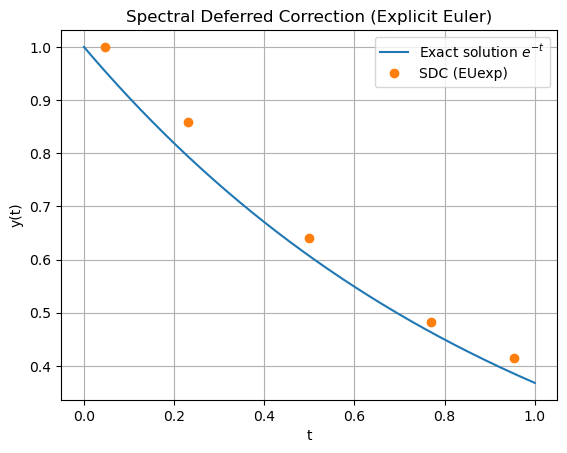

In [11]:
import numpy as np
from numpy.polynomial.legendre import leggauss
import matplotlib.pyplot as plt

def F(t, y):
    return -y

def build_nodes_and_Q(m):
    xi, _ = leggauss(m)
    t = 0.5 * (xi + 1.0)          # map to [0,1]

    xq, wq = leggauss(4 * m)      # high-order quadrature
    tq = 0.5 * (xq + 1.0)
    wq = 0.5 * wq

    # Lagrange basis values at quadrature nodes
    L = np.ones((m, len(tq)))
    for j in range(m):
        for k in range(m):
            if k != j:
                L[j] *= (tq - t[k]) / (t[j] - t[k])

    # from 0 to ti
    Q = np.zeros((m, m))
    for i in range(m):
        mask = tq <= t[i] + 1e-14
        for j in range(m):
            Q[i, j] = np.sum(wq[mask] * L[j, mask])

    return t, Q

def sdc_sweep_explicit(t, Q, y, y0):
    eps = y0 + Q @ F(t, y) - y
    delta = np.zeros_like(y)
    for i in range(len(t) - 1):
        dt = t[i+1] - t[i]
        G = F(t[i], y[i] + delta[i]) - F(t[i], y[i])
        delta[i+1] = delta[i] + dt * G + (eps[i+1] - eps[i])
    return y + delta

def spectral_SDC(m, K):
    t, Q = build_nodes_and_Q(m)
    y0 = 1.0

    # Initial guess: Euler-like constant
    y = y0 * np.ones(m)

    for k in range(K):
        y_new = sdc_sweep_explicit(t, Q, y, y0)

        # convergence check
        if np.linalg.norm(y_new - y, ord=np.inf) < 1e-12:
            y = y_new
            print(f"Converged after {k+1} SDC sweeps")
            break

        y = y_new

    return t, y, Q

if __name__ == "__main__":
    t, y_sdc, Q = spectral_SDC(m=5, K=6)

    ones = np.ones_like(t)
    print("\nSanity check: max|Q*1 - t| =", np.max(np.abs(Q @ ones - t)))

    y_exact = np.exp(-t)
    max_err = np.max(np.abs(y_sdc - y_exact))

    print("\nGauss–Legendre nodes:")
    print(t)

    print("\nSpectral integration matrix Q:")
    np.set_printoptions(precision=6, suppress=True)
    print(Q)

    print("\nSDC approximation:", y_sdc)
    print("Exact solution    :", y_exact)
    print("Max error         :", max_err)

    # Plot
    t_plot = np.linspace(0, 1, 400)
    y_plot = np.exp(-t_plot)

    plt.figure()
    plt.plot(t_plot, y_plot, label="Exact solution $e^{-t}$")
    plt.plot(t, y_sdc, "o", label="SDC (EUexp)")
    plt.xlabel("t")
    plt.ylabel("y(t)")
    plt.title("Spectral Deferred Correction (Explicit Euler)")
    plt.legend()
    plt.grid(True)
    plt.show()

SDC (EUexp, Lobatto), m = 5, K = 4
Expected order ≈ min(m, K+1) = 5

N =   10,  h = 0.10000000,  |error| = 4.919e-08
N =   20,  h = 0.05000000,  |error| = 1.239e-08
N =   40,  h = 0.02500000,  |error| = 3.101e-09
N =   80,  h = 0.01250000,  |error| = 7.755e-10
N =  160,  h = 0.00625000,  |error| = 1.939e-10

Observed orders:
  10 ->   20 :  p ≈ 1.9891
  20 ->   40 :  p ≈ 1.9981
  40 ->   80 :  p ≈ 1.9996
  80 ->  160 :  p ≈ 1.9999


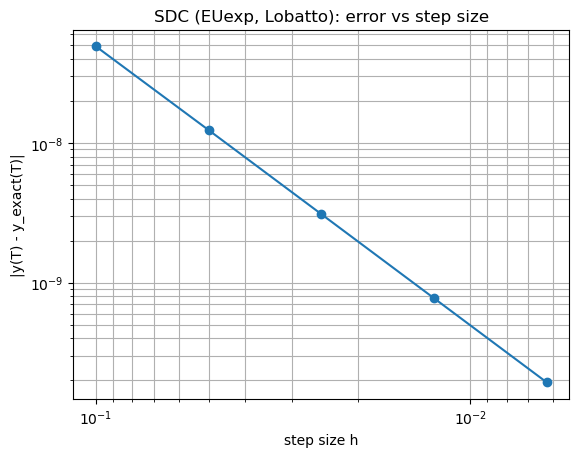

In [2]:
import numpy as np
from numpy.polynomial.legendre import leggauss
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt

# ODE: y' = -y
def F(t, y):
    return -y

def exact(t):
    return np.exp(-t)

def legendre_gauss_lobatto_nodes(m):
    """
    Return m Legendre–Gauss–Lobatto nodes on [-1,1], including endpoints -1 and 1.
    Interior nodes are roots of P'_{m-1}(x).
    """
    if m < 2:
        raise ValueError("m must be >= 2")

    if m == 2:
        x = np.array([-1.0, 1.0])
    else:
        P = Legendre.basis(m - 1)          # P_{m-1}
        dP = P.deriv()                     # P'_{m-1}
        x_int = np.sort(dP.roots())        # interior nodes in (-1,1)
        x = np.concatenate(([-1.0], x_int, [1.0]))

    # map to [0,1]
    tau = 0.5 * (x + 1.0)
    return tau

def build_Q_unit_lobatto(tau):
    m = len(tau)

    # high-order quadrature for robustness
    xq, wq = leggauss(8 * m)
    tq = 0.5 * (xq + 1.0)     # [0,1]
    wq = 0.5 * wq

    # Lagrange basis at quadrature nodes
    L = np.ones((m, len(tq)))
    for j in range(m):
        for k in range(m):
            if k != j:
                L[j] *= (tq - tau[k]) / (tau[j] - tau[k])

    Q = np.zeros((m, m))
    for i in range(m):
        mask = tq <= tau[i] + 1e-14
        for j in range(m):
            Q[i, j] = np.sum(wq[mask] * L[j, mask])

    return Q

def sdc_step_euexp(t_n, y_n, h, tau, Q_unit, K):
    t = t_n + h * tau                 # physical nodes (includes t_n and t_{n+1})
    Q = h * Q_unit                    # scale integral matrix to this step
    m = len(t)

    # predictor: explicit Euler along sub-intervals between nodes
    y = np.zeros(m)
    y[0] = y_n
    for i in range(m - 1):
        h_i = t[i+1] - t[i]
        y[i+1] = y[i] + h_i * F(t[i], y[i])

    # correction sweeps
    for _ in range(K):
        y_old = y.copy()
        f_old = F(t, y_old)

        y_new = np.zeros(m)
        y_new[0] = y_n

        for i in range(m - 1):
            h_i = t[i+1] - t[i]

            # high-order quadrature increment over [t_i, t_{i+1}]
            I_hi = np.dot(Q[i+1, :] - Q[i, :], f_old)

            # EUexp SDC update (node-to-node correction form)
            y_new[i+1] = (
                y_new[i]
                + h_i * (F(t[i], y_new[i]) - f_old[i])
                + I_hi
            )

        y = y_new

    # because Lobatto includes the right endpoint, y[-1] is y_{n+1}
    return y[-1]

def solve_SDC(T, N, m, K):
    tau = legendre_gauss_lobatto_nodes(m)
    Q_unit = build_Q_unit_lobatto(tau)

    h = T / N
    t_n = 0.0
    y_n = 1.0

    for _ in range(N):
        y_n = sdc_step_euexp(t_n, y_n, h, tau, Q_unit, K)
        t_n += h

    return y_n

def convergence_study(T=1.0, m=5, K=4, Ns=(10, 20, 40, 80, 160)):
    print(f"SDC (EUexp, Lobatto), m = {m}, K = {K}")
    print(f"Expected order ≈ min(m, K+1) = {min(m, K+1)}\n")

    results = []
    for N in Ns:
        h = T / N
        yT = solve_SDC(T, N, m, K)
        err = abs(yT - exact(T))
        results.append((N, h, err))
        print(f"N = {N:4d},  h = {h:.8f},  |error| = {err:.3e}")

    print("\nObserved orders:")
    for i in range(1, len(results)):
        e1 = results[i-1][2]
        e2 = results[i][2]
        p = np.log(e1 / e2) / np.log(2.0)
        print(f"{results[i-1][0]:4d} -> {results[i][0]:4d} :  p ≈ {p:.4f}")

    return results

if __name__ == "__main__":
    T = 1.0
    m = 5
    K = 4
    Ns = (10, 20, 40, 80, 160)

    results = convergence_study(T, m, K, Ns)

    hs = np.array([r[1] for r in results])
    errs = np.array([r[2] for r in results])

    plt.figure()
    plt.loglog(hs, errs, "o-")
    plt.gca().invert_xaxis()
    plt.xlabel("step size h")
    plt.ylabel("|y(T) - y_exact(T)|")
    plt.title("SDC (EUexp, Lobatto): error vs step size")
    plt.grid(True, which="both")
    plt.show()